<a href="https://colab.research.google.com/github/maz-joko78/VTCI-LANDSAT-LC08-C02-T1_L2/blob/main/slope_ProfJae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from IPython import get_ipython
from IPython.display import display
# %%
# Install necessary libraries
!pip install numpy rasterio matplotlib scikit-learn geopandas # Added geopandas

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



CRS LST: EPSG:4326
CRS NDVI: EPSG:4326
CRS AOI: EPSG:4326

Jumlah piksel setelah filter NDVI > 0 dan LST > 0: 6541304
Persamaan LSTmax (Dry Edge): LST = -91.0516 * NDVI + 107.9905
Persamaan LSTmin (Wet Edge): LST = 74.1465 * NDVI + -57.2017


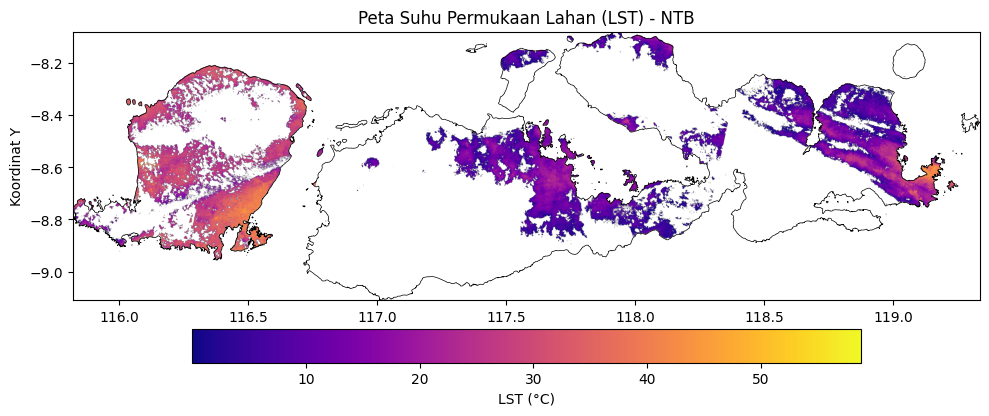

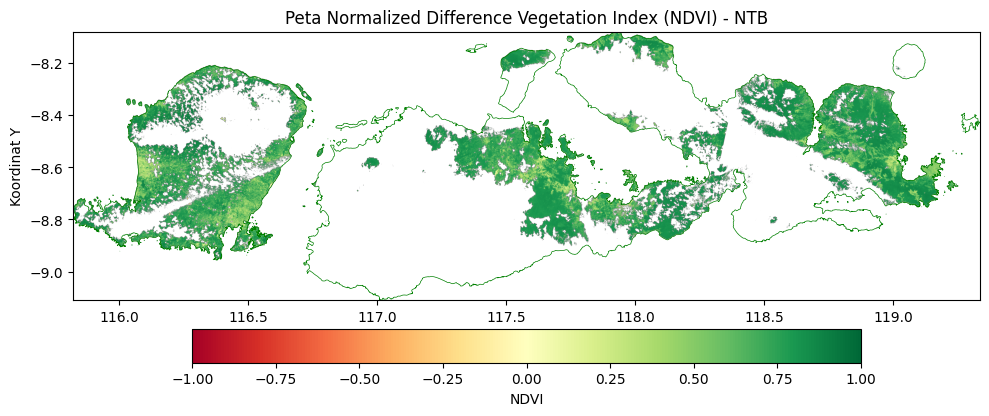

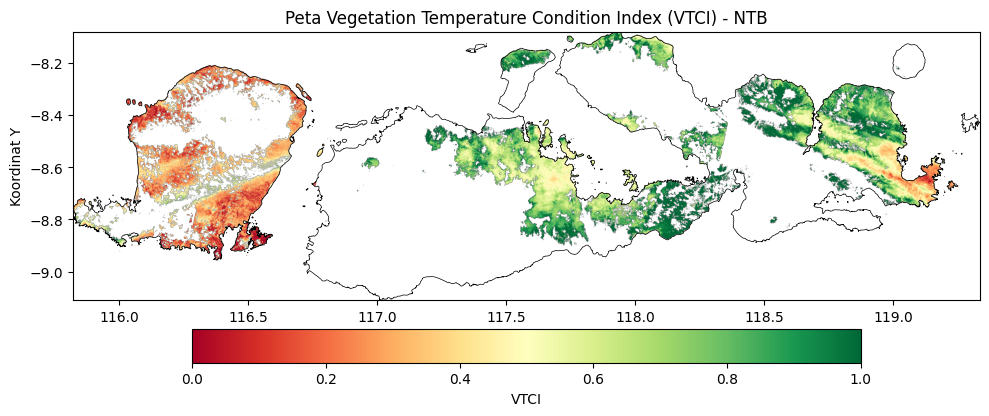

<ipython-input-4-5f09d8195151>:353: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
<ipython-input-4-5f09d8195151>:356: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(output_folder, 'Scatter_Plot_LST_NDVI_Edges.png'))
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


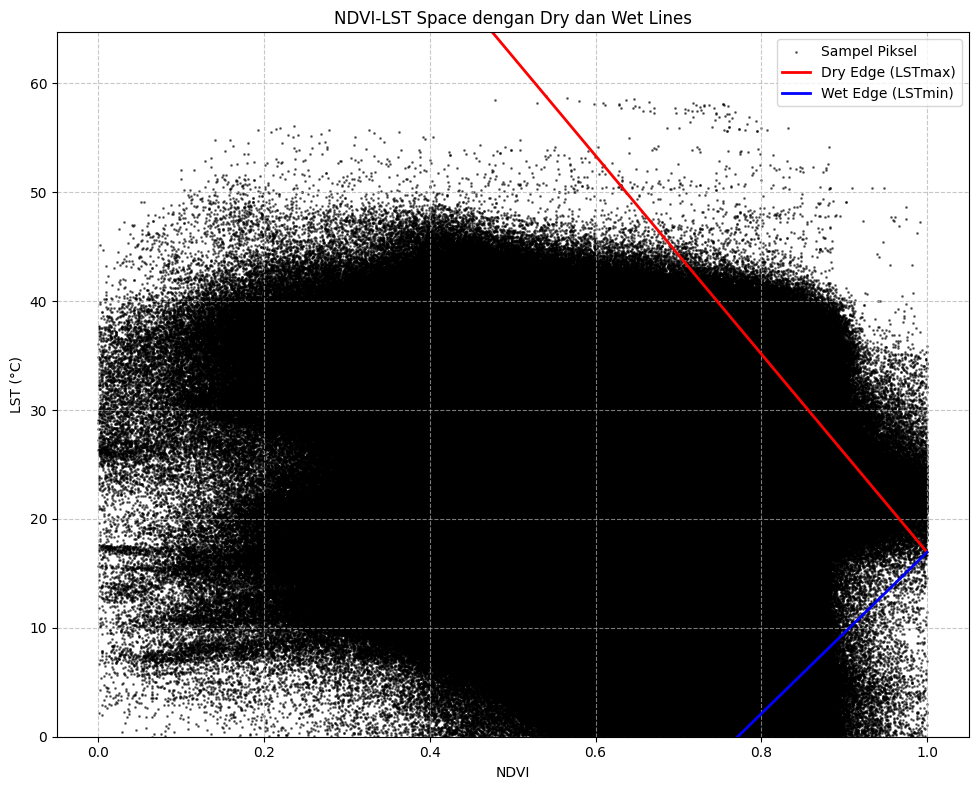

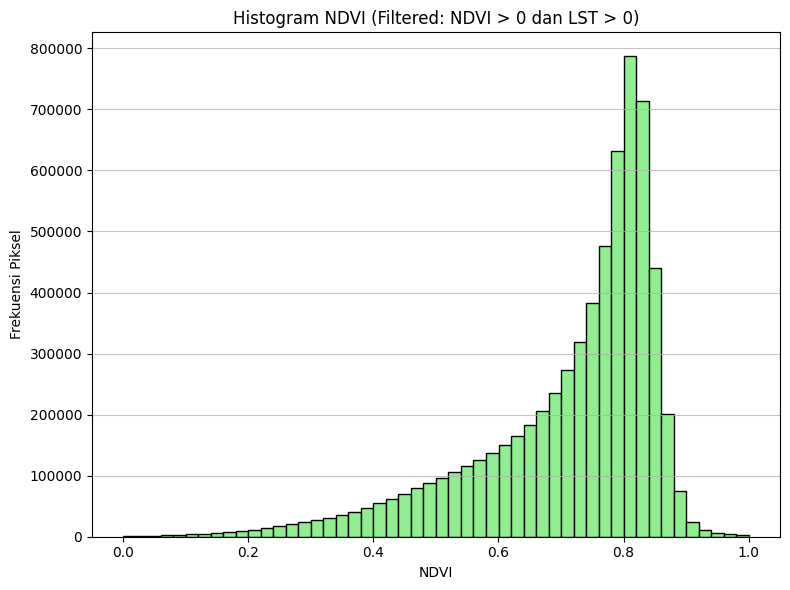

Peta VTCI berhasil diekspor ke: /content/drive/MyDrive/Data_2022/Output2022/VTCI_NTB.tif
Analisis VTCI selesai.


In [4]:
# Pastikan Anda telah menginstal pustaka-pustaka ini sebelumnya di Colab:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd
import os
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# Definisikan path ke folder Anda di Google Drive
# Sesuaikan path ini dengan lokasi file Anda
drive_folder = '/content/drive/MyDrive/Data_2022/'

# Pastikan folder output ada
output_folder = os.path.join(drive_folder, 'Output2022/')
os.makedirs(output_folder, exist_ok=True)

# Definisikan path file input (sesuaikan nama file jika perlu)
lst_path = os.path.join(drive_folder, '2022LST_Bulan_1.tif')
ndvi_path = os.path.join(drive_folder, '2022NDVI_Bulan_1.tif')
aoi_path = os.path.join(drive_folder, 'NTB.shp')


# 2. Muat data LST, NDVI, dan AOI untuk PERHITUNGAN & Visualisasi
try:
    # Muat LST untuk perhitungan (mungkin tidak masked=True jika nodata perlu diperlakukan sebagai nilai sebenarnya untuk langkah awal)
    # Atau baca masked=True, lalu tangani NaNs nanti.
    with rasterio.open(lst_path) as src:
        lst_data = src.read(1) # Baca data untuk perhitungan
        lst_meta = src.meta
        lst_transform = src.transform
        lst_crs = src.crs # Ambil CRS dari raster LST
        output_nodata = src.nodata # Ambil nilai nodata jika ada

    with rasterio.open(ndvi_path) as src:
        ndvi_data = src.read(1) # Baca data untuk perhitungan
        ndvi_meta = src.meta
        ndvi_transform = src.transform
        ndvi_crs = src.crs # Ambil CRS dari raster NDVI

    # Muat data untuk visualisasi dengan masked=True
    with rasterio.open(lst_path, masked=True) as src:
        lst_full_viz = src.read(1, masked=True)
        # Hitung extent dari metadata untuk visualisasi
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    with rasterio.open(ndvi_path, masked=True) as src:
        ndvi_full_viz = src.read(1, masked=True)


    # Load the AOI file
    aoi_gdf = None # Inisialisasi aoi_gdf
    aoi_mask = None # Inisialisasi aoi_mask
    try:
        aoi_gdf = gpd.read_file(aoi_path)
        # Optional: Reproject AOI to raster's CRS if they don't match
        if aoi_gdf.crs is None:
             print("Peringatan: AOI shapefile tidak memiliki CRS yang ditentukan.")
        elif aoi_gdf.crs != lst_crs:
            print(f"Memproyeksikan ulang AOI dari {aoi_gdf.crs} ke CRS LST {lst_crs}")
            aoi_gdf = aoi_gdf.to_crs(lst_crs)
            print("Proyeksi ulang AOI berhasil.")
        # print(f"AOI loaded with CRS: {aoi_gdf.crs}") # Uncomment to print AOI CRS

        # Rasterize the AOI GeoDataFrame to create a mask
        # Import the necessary function
        from rasterio.features import rasterize
        # Create a mask where the AOI polygon is True (or 1) and outside is False (or 0)
        # Use the shape, transform, and CRS of the raster data for consistency
        aoi_mask = rasterize(
            [(shape, 1) for shape in aoi_gdf.geometry],
            out_shape=lst_data.shape, # Use shape from raster data for calculation
            transform=lst_transform,  # Use transform from raster data for calculation
            all_touched=True, # Include pixels touched by polygon boundary
            fill=0,           # Value for pixels outside the AOI
            dtype='uint8'     # Data type for the mask
        )
        # Convert the mask to boolean or use it as is for multiplication
        aoi_mask = aoi_mask.astype(bool) # Convert to boolean mask

    except Exception as e:
        print(f"Error loading or reprojecting AOI file or creating AOI mask: {e}")
        aoi_gdf = None # Set to None if loading/reprojection fails
        aoi_mask = None # Ensure aoi_mask is None if there was an error
        print("Pastikan file AOI ('NTB.shp') berada di lokasi yang benar dan memiliki CRS yang valid.")


except Exception as e:
    print(f"Error loading input raster files: {e}")
    print("Pastikan file LST dan NDVI ('2022LST_Bulan_1.tif', '2022NDVI_Bulan_1.tif') berada di lokasi yang benar.")
    exit()

# 2b. Periksa dan Proyeksikan Ulang CRS AOI (sudah dilakukan di blok try/except di atas)
# Periksa apakah CRS LST dan NDVI cocok (seharusnya sama untuk analisis VTCI)
if lst_crs != ndvi_crs:
    print("Peringatan: CRS LST dan NDVI tidak cocok. Analisis mungkin terpengaruh.")
print(f"\nCRS LST: {lst_crs}")
print(f"CRS NDVI: {ndvi_crs}")
print(f"CRS AOI: {aoi_gdf.crs if aoi_gdf is not None else 'Tidak dimuat'}")


# Pastikan kedua raster (untuk perhitungan) memiliki ukuran yang sama
if lst_data.shape != ndvi_data.shape:
    print("Ukuran raster LST dan NDVI untuk perhitungan tidak cocok. Harap periksa data input Anda.")
    exit()

# Ensure aoi_mask was successfully created before attempting to use it
if aoi_mask is None:
    print("AOI mask could not be created. Cannot proceed with AOI masking.")
    # You might want to handle this case, e.g., exit or proceed without masking
    exit()

# Masking data untuk PERHITUNGAN berdasarkan AOI (menggunakan aoi_mask raster)
# aoi_mask sudah dibuat saat memuat data di atas
# Apply the boolean mask to the raster data
lst_data_masked = lst_data[aoi_mask]
ndvi_data_masked = ndvi_data[aoi_mask]


# Flat the masked data for scatter plot and edge calculation
# valid_indices is now redundant as masking already handled valid pixels within AOI
# Use the masked data directly, filtering out NaNs
valid_indices = ~np.isnan(lst_data_masked) & ~np.isnan(ndvi_data_masked)
flattened_lst = lst_data_masked[valid_indices]
flattened_ndvi = ndvi_data_masked[valid_indices]
# Filter samples to NDVI > 0 dan LST > 0
# TAMBAHKAN FILTER LST > 0 DI SINI
# Buat indeks baru untuk data yang sudah difilter berdasarkan NDVI, tambahkan kondisi LST > 0
filtered_indices = (flattened_ndvi > 0) & (flattened_lst > 0)

# Aplikasikan filter LST > 0 ke subset yang sudah difilter
filtered_lst_for_edges = flattened_lst[filtered_indices]
filtered_ndvi_for_edges = flattened_ndvi[filtered_indices]


print(f"\nJumlah piksel setelah filter NDVI > 0 dan LST > 0: {len(filtered_lst_for_edges)}")

# Periksa apakah masih ada data yang tersisa setelah filter
if len(filtered_lst_for_edges) == 0:
    print("Tidak ada piksel yang tersisa setelah filter NDVI > 0 dan LST > 0. Tidak dapat melanjutkan perhitungan.")
    # Masih bisa mencoba memvisualisasikan data input jika Anda mau, tapi VTCI tidak bisa dihitung
    # exit() # Jangan keluar jika ingin visualisasi data input

# 3. Hitung Dry dan Wet Edges (hanya jika ada data yang cukup)
slope_dry = np.nan
intercept_dry = np.nan
slope_wet = np.nan
intercept_wet = np.nan
ndvi_range = np.array([])
lst_max_line = np.array([])
lst_min_line = np.array([])

if len(filtered_lst_for_edges) > 1: # Membutuhkan setidaknya 2 titik untuk regresi
    max_ndvi = np.max(filtered_ndvi_for_edges)
    mean_lst = np.mean(filtered_lst_for_edges)
    max_lst = np.max(filtered_lst_for_edges)
    min_lst = np.min(filtered_lst_for_edges)


    df_samples = pd.DataFrame({'NDVI': filtered_ndvi_for_edges, 'LST': filtered_lst_for_edges})

    # Pastikan DataFrame tidak kosong sebelum mencoba mengambil nilai iloc[0]
    if not df_samples.empty:
        # Menggunakan idxmax/idxmin untuk menghindari masalah jika ada nilai LST yang sama
        # Pastikan LST max/min tidak NaN jika ada kasus ekstrim setelah filtering
        if not np.isnan(max_lst):
             ndvi_when_max_lst = df_samples.loc[df_samples['LST'].idxmax(), 'NDVI']
        else:
             ndvi_when_max_lst = np.nan

        if not np.isnan(min_lst):
             ndvi_when_min_lst = df_samples.loc[df_samples['LST'].idxmin(), 'NDVI']
        else:
             ndvi_when_min_lst = np.nan
    else:
        print("DataFrame kosong setelah filtering, tidak dapat menentukan NDVI saat LST min/max.")
        ndvi_when_max_lst = np.nan
        ndvi_when_min_lst = np.nan


    # Dry Line (Warm Edge)
    # Slope dry line di skrip GEE adalah: (maxLST - meanLST) / (ndviWhenMaxLST - maxNDVI)
    # Pastikan pembagian tidak oleh nol dan nilai-nilai tidak NaN
    if (ndvi_when_max_lst is not np.nan and max_ndvi is not np.nan and
        (ndvi_when_max_lst - max_ndvi) != 0):
        slope_dry = (max_lst - mean_lst) / (ndvi_when_max_lst - max_ndvi)
        intercept_dry = mean_lst - slope_dry * max_ndvi
    else:
        # Atur slope dan intercept dry menjadi NaN jika perhitungan tidak valid
        slope_dry = np.nan
        intercept_dry = np.nan
        print("Peringatan: Tidak dapat menghitung Dry Edge (slope/intercept menjadi NaN).")


    # Wet Line (Cold Edge)
    # Slope wet line di skrip GEE adalah: (minLST - meanLST) / (ndviWhenMinLST - maxNDVI)
    # Pastikan pembagian tidak oleh nol dan nilai-nilai tidak NaN
    if (ndvi_when_min_lst is not np.nan and max_ndvi is not np.nan and
        (ndvi_when_min_lst - max_ndvi) != 0):
        slope_wet = (min_lst - mean_lst) / (ndvi_when_min_lst - max_ndvi)
        intercept_wet = mean_lst - slope_wet * max_ndvi
    else:
         # Atur slope dan intercept wet menjadi NaN jika perhitungan tidak valid
        slope_wet = np.nan
        intercept_wet = np.nan
        print("Peringatan: Tidak dapat menghitung Wet Edge (slope/intercept menjadi NaN).")


    # Buat array NDVI untuk garis hanya jika slopes valid
    if not np.isnan(slope_dry) and not np.isnan(slope_wet):
        # Pastikan range NDVI untuk garis menggunakan data yang sudah difilter
        if len(filtered_ndvi_for_edges) > 1: # Perlu setidaknya 2 nilai untuk rentang
            ndvi_range = np.linspace(np.min(filtered_ndvi_for_edges), np.max(filtered_ndvi_for_edges), 100)
            # Persamaan LSTmax (Dry Edge)
            lst_max_line = slope_dry * ndvi_range + intercept_dry
            print(f"Persamaan LSTmax (Dry Edge): LST = {slope_dry:.4f} * NDVI + {intercept_dry:.4f}")

            # Persamaan LSTmin (Wet Edge)
            lst_min_line = slope_wet * ndvi_range + intercept_wet
            print(f"Persamaan LSTmin (Wet Edge): LST = {slope_wet:.4f} * NDVI + {intercept_wet:.4f}")
        else:
            print("Tidak cukup data NDVI untuk membuat rentang garis.")
            ndvi_range = np.array([])
            lst_max_line = np.array([])
            lst_min_line = np.array([])
else:
    print("Tidak cukup piksel setelah filter untuk menghitung Dry dan Wet Edges.")


# 4. Hitung VTCI (hanya jika slopes valid dan ada data visualisasi)
vtci_full = np.full(lst_full_viz.shape, np.nan, dtype=np.float32) # Inisialisasi VTCI array
if not np.isnan(slope_dry) and not np.isnan(slope_wet):
    # LSTmax (Dry Edge) untuk setiap piksel di peta (menggunakan data visualisasi)
    lst_max_map_viz = slope_dry * ndvi_full_viz + intercept_dry

    # LSTmin (Wet Edge) untuk setiap piksel di peta (menggunakan data visualisasi)
    lst_min_map_viz = slope_wet * ndvi_full_viz + intercept_wet

    # Hitung VTCI dengan rumus yang dikoreksi: VTCI = (LSTmax - LST) / (LSTmax - LSTmin)
    denominator_viz = (lst_max_map_viz - lst_min_map_viz)
    denominator_viz[np.abs(denominator_viz) < 1e-6] = np.nan # Hindari pembagian dengan nol

    vtci_full = (lst_max_map_viz - lst_full_viz) / denominator_viz

    # Batasi nilai VTCI antara 0 dan 1
    vtci_full[vtci_full < 0] = 0
    vtci_full[vtci_full > 1] = 1

    # Masking VTCI berdasarkan area yang valid dari input LST/NDVI (data visualisasi)
    # Pastikan VTCI NaN di mana data LST asli juga NaN
    vtci_full[np.ma.getmaskarray(lst_full_viz)] = np.nan # Masking berdasarkan masked array LST
    vtci_full[np.ma.getmaskarray(ndvi_full_viz)] = np.nan # Masking berdasarkan masked array NDVI

    # Masking VTCI berdasarkan AOI jika aoi_mask (raster) tersedia
    if aoi_mask is not None:
        vtci_full[np.isnan(aoi_mask)] = np.nan


else:
    print("VTCI tidak dihitung karena slope Dry/Wet tidak valid.")


# 5. Visualisasi Peta (menggunakan data visualisasi _viz dan extent)

# --- Peta LST ---
plt.figure(figsize=(10, 8))
ax = plt.gca() # Dapatkan Axes saat ini

# Masking nilai LST < 0 Celcius untuk VISUALISASI (Opsional, perhitungan sudah difilter)
lst_display = lst_full_viz.copy()
lst_display[lst_display < 0] = np.nan # Setel nilai < 0 menjadi NaN untuk tampilan

# Tampilkan raster LST dengan extent
im1 = ax.imshow(lst_display, cmap='plasma', origin='upper', extent=extent) # Menggunakan extent
# Atur colorbar di bawah peta dan horizontal
plt.colorbar(im1, orientation='horizontal', fraction=0.046, pad=0.04, label='LST (°C)') # Sesuaikan label

# Tambahkan batas AOI jika aoi_gdf berhasil dimuat
if aoi_gdf is not None:
    aoi_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, facecolor='none') # Plot batas AOI

plt.title('Peta Suhu Permukaan Lahan (LST) - NTB')
plt.xlabel('Koordinat X') # Ganti label sumbu jika extent adalah koordinat geografis
plt.ylabel('Koordinat Y') # Ganti label sumbu jika extent adalah koordinat geografis
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'Peta_LST_NTB.png'))
plt.show()


# --- Peta NDVI ---
plt.figure(figsize=(10, 8))
ax = plt.gca() # Dapatkan Axes saat ini

# Tampilkan raster NDVI dengan extent
im2 = ax.imshow(ndvi_full_viz, cmap='RdYlGn', origin='upper', extent=extent, vmin=-1, vmax=1)
# Atur colorbar di bawah peta dan horizontal
plt.colorbar(im2, orientation='horizontal', fraction=0.046, pad=0.04, label='NDVI') # Sesuaikan label

# Tambahkan batas AOI jika aoi_gdf berhasil dimuat
if aoi_gdf is not None:
    aoi_gdf.boundary.plot(ax=ax, edgecolor='green', linewidth=0.5, facecolor='none') # Plot batas AOI

plt.title('Peta Normalized Difference Vegetation Index (NDVI) - NTB')
plt.xlabel('Koordinat X') # Ganti label sumbu jika extent adalah koordinat geografis
plt.ylabel('Koordinat Y') # Ganti label sumbu jika extent adalah koordinat geografis
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'Peta_NDVI_NTB.png'))
plt.show()


# --- Peta VTCI ---
# Periksa jika array VTCI mengandung nilai valid sebelum plotting
if not np.all(np.isnan(vtci_full)):
    plt.figure(figsize=(10, 8))
    ax = plt.gca() # Dapatkan Axes saat ini

    # Tampilkan raster VTCI dengan extent
    im3 = ax.imshow(vtci_full, cmap='RdYlGn', origin='upper', extent=extent, vmin=0, vmax=1)
    # Atur colorbar di bawah peta dan horizontal
    plt.colorbar(im3, orientation='horizontal', fraction=0.046, pad=0.04, label='VTCI')

    # Tambahkan batas AOI jika aoi_gdf berhasil dimuat
    if aoi_gdf is not None:
        aoi_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, facecolor='none') # Plot batas AOI

    plt.title('Peta Vegetation Temperature Condition Index (VTCI) - NTB')
    plt.xlabel('Koordinat X') # Ganti label sumbu jika extent adalah koordinat geografis
    plt.ylabel('Koordinat Y') # Ganti label sumbu jika extent adalah koordinat geografis
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'Peta_VTCI_NTB.png'))
    plt.show()
else:
    print("Peta VTCI tidak ditampilkan karena tidak berhasil dihitung atau semua nilainya NaN.")


# --- Scatter Plot LST vs NDVI dengan Warm/Cold Edges ---
# Pastikan ada data yang tersisa untuk diplot
if len(filtered_ndvi_for_edges) > 0 and len(ndvi_range) > 0:
    plt.figure(figsize=(10, 8))
    # Scatter plot menggunakan data yang sudah difilter untuk edges
    plt.scatter(filtered_ndvi_for_edges, filtered_lst_for_edges, s=1, alpha=0.5, label='Sampel Piksel', c='black')
    plt.plot(ndvi_range, lst_max_line, color='red', linewidth=2, label='Dry Edge (LSTmax)')
    plt.plot(ndvi_range, lst_min_line, color='blue', linewidth=2, label='Wet Edge (LSTmin)')
    plt.title('NDVI-LST Space dengan Dry dan Wet Lines')
    plt.xlabel('NDVI')
    plt.ylabel('LST (°C)') # Sesuaikan label Y jika Anda mengonversi LST
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    # Batasi sumbu y (LST) dari 0 hingga sedikit di atas LST max (menggunakan max_lst dari data terfilter)
    plt.ylim(bottom=0, top=max_lst * 1.1)
    plt.savefig(os.path.join(output_folder, 'Scatter_Plot_LST_NDVI_Edges.png'))
    plt.show()
else:
    print("Scatter Plot tidak ditampilkan karena tidak ada data yang tersisa setelah filter atau garis tidak berhasil dihitung.")


# --- Histogram NDVI (filtered) ---
# (hanya jika ada data yang tersisa setelah filter untuk edges)
if len(filtered_ndvi_for_edges) > 0:
    plt.figure(figsize=(8, 6))
    plt.hist(filtered_ndvi_for_edges.flatten(), bins=50, color='lightgreen', edgecolor='black')
    plt.title('Histogram NDVI (Filtered: NDVI > 0 dan LST > 0)')
    plt.xlabel('NDVI')
    plt.ylabel('Frekuensi Piksel')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'Histogram_NDVI_Filtered.png'))
    plt.show()
else:
    print("Histogram NDVI tidak ditampilkan karena tidak ada data yang tersisa setelah filter.")


# 6. Ekspor VTCI sebagai GeoTIFF (hanya jika VTCI berhasil dihitung)
if not np.all(np.isnan(vtci_full)): # Periksa vtci_full
    # Gunakan metadata dari LST asli sebagai dasar
    vtci_meta = lst_meta.copy()
    vtci_meta.update({
        'dtype': 'float32',
        'count': 1,
        'nodata': np.nan # Menetapkan NaN sebagai nilai nodata
    })

    output_vtci_path = os.path.join(output_folder, 'VTCI_NTB.tif')
    # Tulis vtci_full ke file GeoTIFF
    with rasterio.open(output_vtci_path, 'w', **vtci_meta) as dst:
        # Pastikan data yang ditulis adalah vtci_full
        dst.write(vtci_full.astype(vtci_meta['dtype']), 1)

    print(f"Peta VTCI berhasil diekspor ke: {output_vtci_path}")
else:
    print("Peta VTCI tidak diekspor karena tidak berhasil dihitung atau semua nilainya NaN.")


print("Analisis VTCI selesai.")